In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np
from tqdm import tqdm

2024.1.25


In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')
job.filter_proxydb(by='ptype', keys=['coral'])
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyDatabase: 100%|██████████| 104/104 [00:01<00:00, 67.33it/s]

>>> 99 records remaining
>>> job.proxydb updated


In [3]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': 'gistemp1200_GHCNv4_ERSSTv5', # load from the cloud
    },
    rename_dict={'tas': 'tempanomaly'},
    anom_period=(1951, 1980),
    load=True,  # load the data into memeory to accelerate the later access; requires large memeory
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': 'gistemp1200_GHCNv4_ERSSTv5'}
>>> job.configs["obs_rename_dict"] = {'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> The target file seems existed at: ./data/gistemp1200_GHCNv4_ERSSTv5.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['tas'] loaded
>>> job.obs created


In [4]:
job.annualize_clim(tag='obs', verbose=True, months=[12, 1, 2])
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
job.crop_clim(tag='obs', lat_min=-20, lat_max=20, lon_min=150, lon_max=260, verbose=True)

>>> job.configs["obs_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.obs updated
>>> job.configs["obs_regrid_nlat"] = 42
>>> job.configs["obs_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["obs_lat_min"] = -20
>>> job.configs["obs_lat_max"] = 20
>>> job.configs["obs_lon_min"] = 150
>>> job.configs["obs_lon_max"] = 260
>>> Processing tas ...


In [5]:
job.prep_graphem(
    recon_period=(1871, 2000),  # period to reconstruct
    calib_period=(1901, 2000),  # period for calibration
    uniform_pdb=True,           # filter the proxydb to be more uniform
    verbose=True,
)

>>> job.configs["recon_period"] = [1871, 2000]
>>> job.configs["recon_timescale"] = 1
>>> job.configs["calib_period"] = [1901, 2000]
>>> job.configs["uniform_pdb"] = True
>>> ProxyDatabase filtered to be more uniform. 54 records remaining.
>>> job.configs["proxydb_center_ref_period"] = [1901, 2000]


Centering each of the ProxyRecord: 100%|██████████| 54/54 [00:00<00:00, 2377.72it/s]

>>> job.proxydb updated
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created


>>> job.graphem_params["field_obs"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


In [6]:
# locate our target site
job.proxydb.plotly_concise()

# 'Ocn_103'

In [7]:
target_site_idx = list(job.graphem_params['df_proxy'].columns).index('Ocn_103')

In [8]:
G = cfr.graphem.Graph(
    job.graphem_params['lonlat'],
    job.graphem_params['field'],
    job.graphem_params['proxy'],
)
G.neigh_adj(cutoff_radius=5000)

Text(0.5, 1.0, 'Target site: Ocn_088')

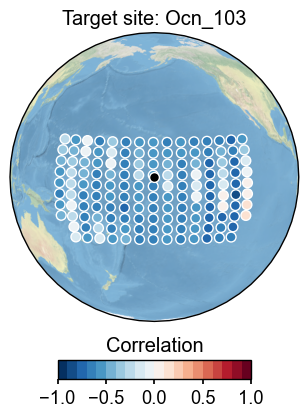

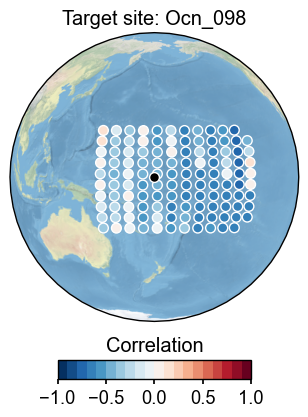

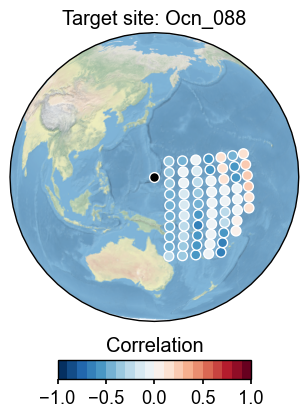

In [47]:
# for i in range(len(job.graphem_params['df_proxy'].columns)):
#     fig, ax = G.plot_neighbors_corr(i)
#     ax.text(1, 1, job.graphem_params['df_proxy'].columns[i])
    # break

stat = 'corr'

target_site_idx = list(job.graphem_params['df_proxy'].columns).index('Ocn_103')
fig, ax = G.plot_neighbors_corr(target_site_idx, stat=stat)
ax.set_title(f"Target site: {job.graphem_params['df_proxy'].columns[target_site_idx]}")

target_site_idx = list(job.graphem_params['df_proxy'].columns).index('Ocn_098')
fig, ax = G.plot_neighbors_corr(target_site_idx, stat=stat)
ax.set_title(f"Target site: {job.graphem_params['df_proxy'].columns[target_site_idx]}")

target_site_idx = list(job.graphem_params['df_proxy'].columns).index('Ocn_088')
fig, ax = G.plot_neighbors_corr(target_site_idx, stat=stat)
ax.set_title(f"Target site: {job.graphem_params['df_proxy'].columns[target_site_idx]}")
# cfr.showfig(fig)
# cfr.savefig(fig, f'./figs/graphem-graph_corr-Ocn_129.pdf')

In [37]:
res = cfr.ReconRes('./recons/graphem-real-pages2k')
res.load(['nino3.4', 'tas'], verbose=True)

target = cfr.ClimateField().fetch('20CRv3/tas', vn='air').rename('tas').get_anom((1951, 1980)).annualize(months=[12, 1, 2])

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> The target file seems existed at: ./data/air.2m.mon.mean.nc . Loading from it instead of downloading ...


-0.4276403859642594


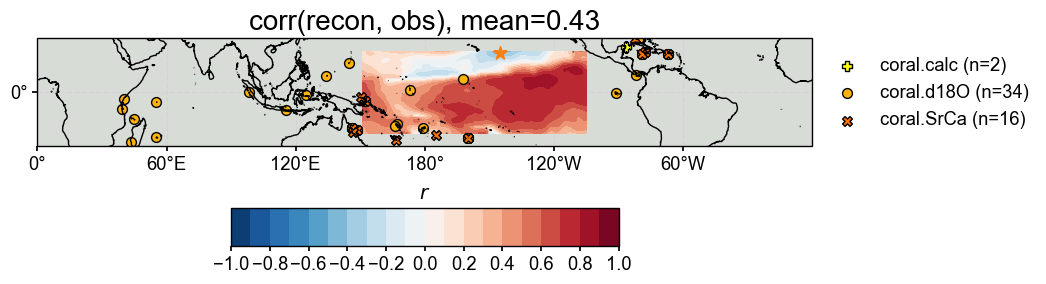

In [43]:
stat = 'corr'

valid_fd = res.recons['tas'].compare(
    target, stat=stat, 
    timespan=(1874, 1900),
)
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'{stat}(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-25, 25, 0, 360),
    plot_cbar=True, plot_proxydb=True, proxydb=job.proxydb, plot_proxydb_lgd=True, 
    proxydb_lgd_kws={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
)

check_lat, check_lon = 18, 215
ax.scatter(check_lon, check_lat, marker='*', c='tab:orange', s=100, transform=ccrs.PlateCarree())
print(valid_fd.da.sel(lat=check_lat, lon=check_lon).values[0])

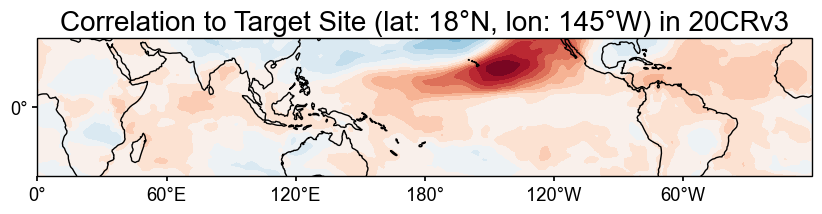

Figure saved at: "figs/graphem_check_spatial.pdf"


In [73]:
target_ts = target.da.sel(lat=check_lat, lon=check_lon)
stat_da_obs = xr.corr(target.da, target_ts.sel(time=slice(1874, 2000)), dim='time').expand_dims({'time': [1]})
stat_da_obs.name = 'corr'
stat_fd_obs = cfr.ClimateField(stat_da_obs)
stat_fd_obs.plot_kwargs = {
    'cmap': 'RdBu_r',
    'extend': 'neither',
    'levels': np.linspace(-1, 1, 21),
    'cbar_labels': np.linspace(-1, 1, 11),
    'cbar_title': r'$r$',
    'cbar_title_y': 1,
    'cbar_orientation': 'horizontal',
    'cbar_pad': 0.1,
}

fig, ax = stat_fd_obs.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    title= r'Correlation to Target Site (lat: 18°N, lon: 145°W) in 20CRv3'
)

cfr.visual.showfig(fig)
cfr.visual.savefig(fig, f'figs/graphem_check_spatial.pdf')

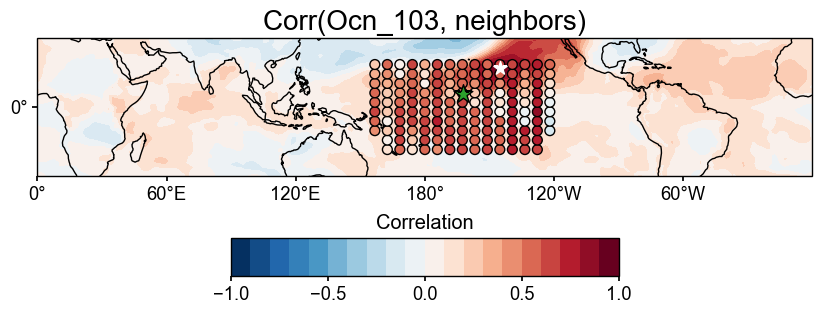

Figure saved at: "figs/graphem_check_spatial_Ocn_103.pdf"


In [81]:
target_ts = target.da.sel(lat=check_lat, lon=check_lon)
stat_da_obs = xr.corr(target.da, target_ts.sel(time=slice(1874, 2000)), dim='time').expand_dims({'time': [1]})
stat_da_obs.name = 'corr'
stat_fd_obs = cfr.ClimateField(stat_da_obs)
stat_fd_obs.plot_kwargs = {
    'cmap': 'RdBu_r',
    'extend': 'neither',
    'levels': np.linspace(-1, 1, 21),
    'cbar_labels': np.linspace(-1, 1, 11),
    'cbar_title': r'$r$',
    'cbar_title_y': 1,
    'cbar_orientation': 'horizontal',
    'cbar_pad': 0.1,
}

pid = 'Ocn_103'
fig, ax = stat_fd_obs.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    title= f'Corr({pid}, neighbors)'
)

idx = list(job.graphem_params['df_proxy'].columns).index(pid)
_, _, _, _, neighbor_idx = G.get_neighbor_locs(idx)
target_value = G.proxy[:, idx]
corrs = []
for i in neighbor_idx:
    neighbor_value = G.field[:, i]
    time_idx_range = ~np.isnan(neighbor_value)

    time_idx_range_target = ~np.isnan(target_value)
    time_idx_common = time_idx_range*time_idx_range_target
    corr = np.corrcoef(neighbor_value[time_idx_common], -target_value[time_idx_common])[1, 0]
    corrs.append(corr)

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

levels=np.linspace(-1, 1, 21)
cbar_labels=[-1, -0.5, 0, 0.5, 1]
cmap = plt.get_cmap('RdBu_r')
cbar_aspect=10
cbar_fraction=0.15
cbar_shrink=0.5
cbar_pad=0.1
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
target_lon, target_lat, neighbor_lons, neighbor_lats, _ = G.get_neighbor_locs(idx)
# G.plot_neighbors(idx, ax=ax, neighbor_clr=corrs, target_clr='k', marker='o', edge_clr='k', cmap=cmap, norm=norm)
ax.scatter(neighbor_lons, neighbor_lats, marker='o', s=50, c=corrs, edgecolor='k',transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, zorder=99)
ax.scatter(target_lon, target_lat, marker='*', s=200, c='tab:green', edgecolor='k', transform=ccrs.PlateCarree(), zorder=99)
ax.scatter(check_lon, check_lat, marker='*', c='white', s=100, transform=ccrs.PlateCarree(), zorder=99)
# ax.scatter(job.proxydb.lons, job.proxydb.lats, marker='o', c='white', edgecolor='k', s=100, transform=ccrs.PlateCarree(), zorder=99)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(smap, ax=ax, orientation='horizontal', pad=cbar_pad, aspect=cbar_aspect, extend='neither', fraction=cbar_fraction, shrink=cbar_shrink)
cbar.ax.set_title('Correlation')
cbar.set_ticks(cbar_labels)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, f'figs/graphem_check_spatial_{pid}.pdf')

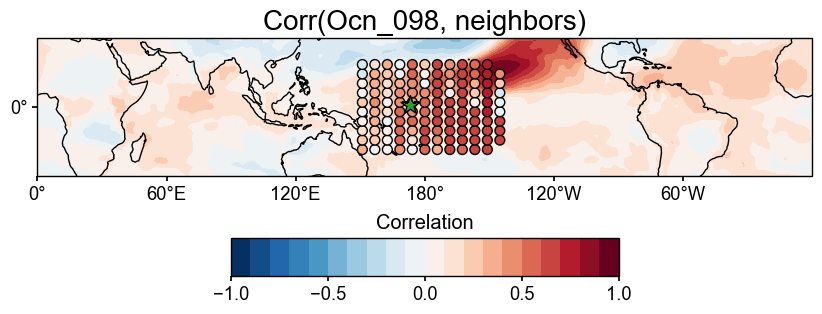

Figure saved at: "figs/graphem_check_spatial_Ocn_098.pdf"


In [77]:
target_ts = target.da.sel(lat=check_lat, lon=check_lon)
stat_da_obs = xr.corr(target.da, target_ts.sel(time=slice(1874, 2000)), dim='time').expand_dims({'time': [1]})
stat_da_obs.name = 'corr'
stat_fd_obs = cfr.ClimateField(stat_da_obs)
stat_fd_obs.plot_kwargs = {
    'cmap': 'RdBu_r',
    'extend': 'neither',
    'levels': np.linspace(-1, 1, 21),
    'cbar_labels': np.linspace(-1, 1, 11),
    'cbar_title': r'$r$',
    'cbar_title_y': 1,
    'cbar_orientation': 'horizontal',
    'cbar_pad': 0.1,
}

pid = 'Ocn_098'
fig, ax = stat_fd_obs.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    title= f'Corr({pid}, neighbors)'
)

idx = list(job.graphem_params['df_proxy'].columns).index(pid)
_, _, _, _, neighbor_idx = G.get_neighbor_locs(idx)
target_value = G.proxy[:, idx]
corrs = []
for i in neighbor_idx:
    neighbor_value = G.field[:, i]
    time_idx_range = ~np.isnan(neighbor_value)

    time_idx_range_target = ~np.isnan(target_value)
    time_idx_common = time_idx_range*time_idx_range_target
    corr = np.corrcoef(neighbor_value[time_idx_common], -target_value[time_idx_common])[1, 0]
    corrs.append(corr)

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

levels=np.linspace(-1, 1, 21)
cbar_labels=[-1, -0.5, 0, 0.5, 1]
cmap = plt.get_cmap('RdBu_r')
cbar_aspect=10
cbar_fraction=0.15
cbar_shrink=0.5
cbar_pad=0.1
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
target_lon, target_lat, neighbor_lons, neighbor_lats, _ = G.get_neighbor_locs(idx)
ax.scatter(neighbor_lons, neighbor_lats, marker='o', s=50, c=corrs, edgecolor='k',transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, zorder=99)
ax.scatter(target_lon, target_lat, marker='*', s=200, c='tab:green', edgecolor='k', transform=ccrs.PlateCarree(), zorder=99)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(smap, ax=ax, orientation='horizontal', pad=cbar_pad, aspect=cbar_aspect, extend='neither', fraction=cbar_fraction, shrink=cbar_shrink)
cbar.ax.set_title('Correlation')
cbar.set_ticks(cbar_labels)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, f'figs/graphem_check_spatial_{pid}.pdf')

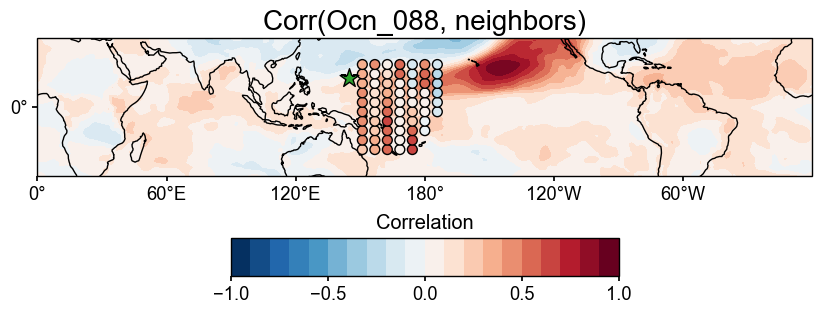

Figure saved at: "figs/graphem_check_spatial_Ocn_088.pdf"


In [78]:
target_ts = target.da.sel(lat=check_lat, lon=check_lon)
stat_da_obs = xr.corr(target.da, target_ts.sel(time=slice(1874, 2000)), dim='time').expand_dims({'time': [1]})
stat_da_obs.name = 'corr'
stat_fd_obs = cfr.ClimateField(stat_da_obs)
stat_fd_obs.plot_kwargs = {
    'cmap': 'RdBu_r',
    'extend': 'neither',
    'levels': np.linspace(-1, 1, 21),
    'cbar_labels': np.linspace(-1, 1, 11),
    'cbar_title': r'$r$',
    'cbar_title_y': 1,
    'cbar_orientation': 'horizontal',
    'cbar_pad': 0.1,
}

pid = 'Ocn_088'
fig, ax = stat_fd_obs.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    title= f'Corr({pid}, neighbors)'
)

idx = list(job.graphem_params['df_proxy'].columns).index(pid)
_, _, _, _, neighbor_idx = G.get_neighbor_locs(idx)
target_value = G.proxy[:, idx]
corrs = []
for i in neighbor_idx:
    neighbor_value = G.field[:, i]
    time_idx_range = ~np.isnan(neighbor_value)

    time_idx_range_target = ~np.isnan(target_value)
    time_idx_common = time_idx_range*time_idx_range_target
    corr = np.corrcoef(neighbor_value[time_idx_common], -target_value[time_idx_common])[1, 0]
    corrs.append(corr)

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

levels=np.linspace(-1, 1, 21)
cbar_labels=[-1, -0.5, 0, 0.5, 1]
cmap = plt.get_cmap('RdBu_r')
cbar_aspect=10
cbar_fraction=0.15
cbar_shrink=0.5
cbar_pad=0.1
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
target_lon, target_lat, neighbor_lons, neighbor_lats, _ = G.get_neighbor_locs(idx)
ax.scatter(neighbor_lons, neighbor_lats, marker='o', s=50, c=corrs, edgecolor='k',transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, zorder=99)
ax.scatter(target_lon, target_lat, marker='*', s=200, c='tab:green', edgecolor='k', transform=ccrs.PlateCarree(), zorder=99)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(smap, ax=ax, orientation='horizontal', pad=cbar_pad, aspect=cbar_aspect, extend='neither', fraction=cbar_fraction, shrink=cbar_shrink)
cbar.ax.set_title('Correlation')
cbar.set_ticks(cbar_labels)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, f'figs/graphem_check_spatial_{pid}.pdf')

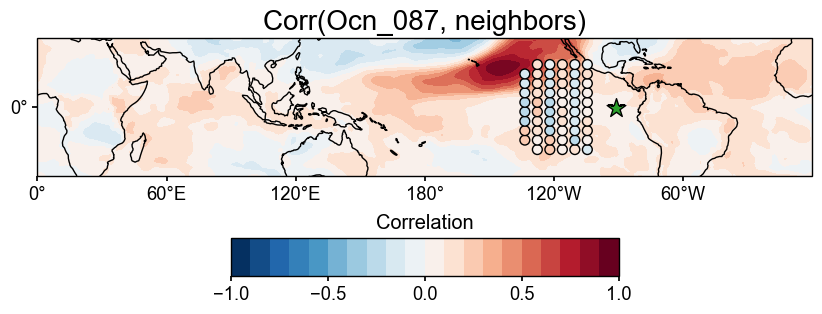

Figure saved at: "figs/graphem_check_spatial_Ocn_087.pdf"


In [79]:
target_ts = target.da.sel(lat=check_lat, lon=check_lon)
stat_da_obs = xr.corr(target.da, target_ts.sel(time=slice(1874, 2000)), dim='time').expand_dims({'time': [1]})
stat_da_obs.name = 'corr'
stat_fd_obs = cfr.ClimateField(stat_da_obs)
stat_fd_obs.plot_kwargs = {
    'cmap': 'RdBu_r',
    'extend': 'neither',
    'levels': np.linspace(-1, 1, 21),
    'cbar_labels': np.linspace(-1, 1, 11),
    'cbar_title': r'$r$',
    'cbar_title_y': 1,
    'cbar_orientation': 'horizontal',
    'cbar_pad': 0.1,
}

pid = 'Ocn_087'
fig, ax = stat_fd_obs.plot(
    projection='PlateCarree',
    central_longitude=180,
    # add_cyclic_point=False,
    latlon_range=(-32, 32, 0, 360),
    plot_cbar=False,
    title= f'Corr({pid}, neighbors)'
)

idx = list(job.graphem_params['df_proxy'].columns).index(pid)
_, _, _, _, neighbor_idx = G.get_neighbor_locs(idx)
target_value = G.proxy[:, idx]
corrs = []
for i in neighbor_idx:
    neighbor_value = G.field[:, i]
    time_idx_range = ~np.isnan(neighbor_value)

    time_idx_range_target = ~np.isnan(target_value)
    time_idx_common = time_idx_range*time_idx_range_target
    corr = np.corrcoef(neighbor_value[time_idx_common], -target_value[time_idx_common])[1, 0]
    corrs.append(corr)

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

levels=np.linspace(-1, 1, 21)
cbar_labels=[-1, -0.5, 0, 0.5, 1]
cmap = plt.get_cmap('RdBu_r')
cbar_aspect=10
cbar_fraction=0.15
cbar_shrink=0.5
cbar_pad=0.1
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
target_lon, target_lat, neighbor_lons, neighbor_lats, _ = G.get_neighbor_locs(idx)
ax.scatter(neighbor_lons, neighbor_lats, marker='o', s=50, c=corrs, edgecolor='k',transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, zorder=99)
ax.scatter(target_lon, target_lat, marker='*', s=200, c='tab:green', edgecolor='k', transform=ccrs.PlateCarree(), zorder=99)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(smap, ax=ax, orientation='horizontal', pad=cbar_pad, aspect=cbar_aspect, extend='neither', fraction=cbar_fraction, shrink=cbar_shrink)
cbar.ax.set_title('Correlation')
cbar.set_ticks(cbar_labels)
cfr.visual.showfig(fig)
cfr.visual.savefig(fig, f'figs/graphem_check_spatial_{pid}.pdf')